<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-model" data-toc-modified-id="Linear-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear model</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>ARIMA</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

## Подготовка

In [2]:
#download the data

data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data.sort_index(inplace=True)

In [5]:
# resample data for 1 hour frequency
data1h = data.resample('1H').sum()

In [6]:
data1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

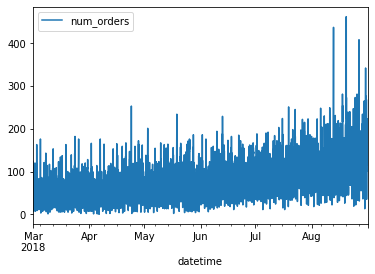

In [7]:
data1h.plot()

There is a lot of data, maybe some increasing trend, the timeseries is non-stationary. We will use rolling mean to have a look at a trend

## Анализ

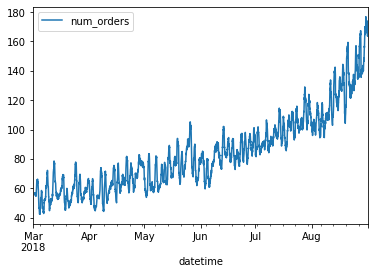

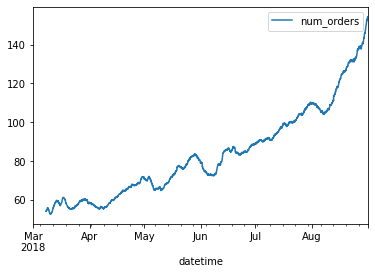

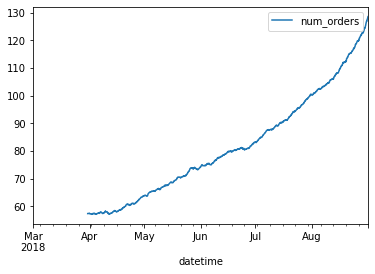

In [8]:
for days in [1,7,30]:
    data1h.rolling(24*days).mean().plot()

With 1-day, 1-week and 1-month rolling mean we see the increasing trend, possibly non-linear but parabolic

<AxesSubplot:xlabel='datetime'>

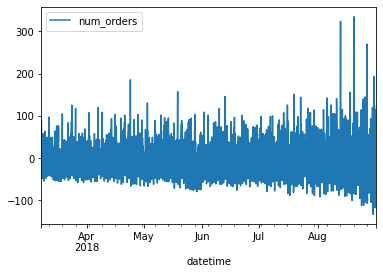

In [9]:
#detrend the series by substracting 1 week rolling mean and look into  
detrended = (data1h - data1h.rolling(24*7).mean())[24*7:]
detrended.plot()

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

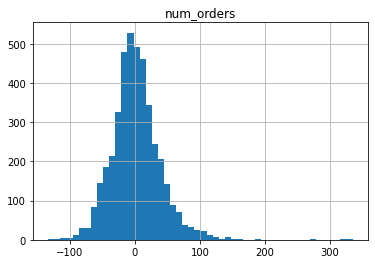

In [10]:
detrended.hist(bins=50)
#looks like normal distribution of noise, so nice but slightly assimetrical

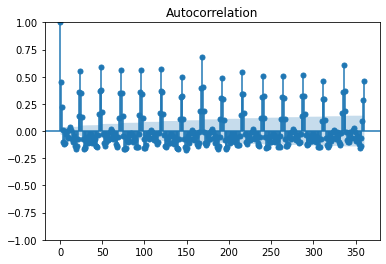

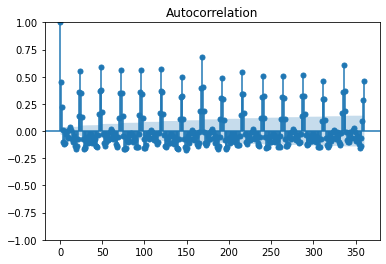

In [11]:
#autocorrelation plot
plot_acf(detrended,lags=24*15, alpha=0.05)

#every 24 hours is a day, so the highest peaks occur every night. Also one can note that evry 7th peak is higher than 
#previous, that means we have a daily and weekly seasonality. Maybe monthly also takes place, but the timeseries
#is too short to approve it

Now use some special tools to divide the series into seasonal, trend and residual components

In [12]:
decomposed = seasonal_decompose(data1h.dropna()) 

<AxesSubplot:xlabel='datetime'>

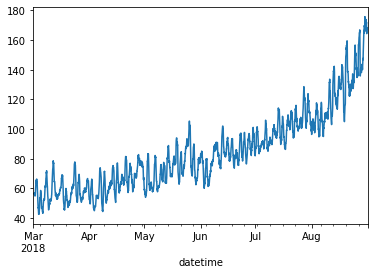

In [13]:
decomposed.trend.plot()

    decomposed.trend — тренд;
    decomposed.seasonal — сезонная составляющая;
    decomposed.resid — остаток декомпозиции.

<AxesSubplot:xlabel='datetime'>

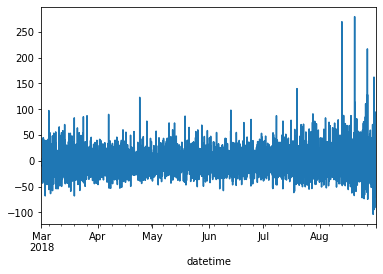

In [14]:
decomposed.resid.plot()

<AxesSubplot:xlabel='datetime'>

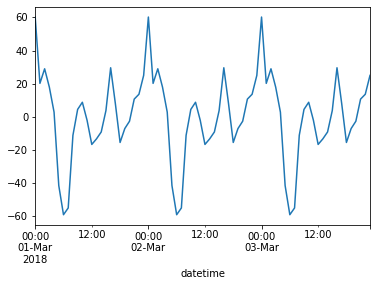

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-03'].plot()

With the special tool we obtained similar result, can see daily seasonality, non-linear increasing trend, non-stationary residuals.

## Обучение

In [16]:
#create features that will contain seasonal information, lags and rolling means 
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [18]:
#make_features(data1h,24*31,24*31)
make_features(data1h,24*31,24*31)

In [19]:
#split the data into train and test
train, test = train_test_split(data1h, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

### Linear model



In [21]:
mdl = LinearRegression()
mdl.fit(train_features, train_target)
pr = mdl.predict(train_features)
print(mean_squared_error(train_target, pr) ** 0.5)

18.316702884264835


In [22]:
print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(mdl,train_features, train_target, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

Значение метрики RMSE на обучающей выборке для LinearRegression -37.620975934831655


### Random Forest

In [23]:
parameters = {'max_depth': [4,10], 'max_leaf_nodes':[2,4], 'n_estimators': [100]}
RF = RandomForestRegressor()
RF_modl = GridSearchCV(RF, parameters,cv = TimeSeriesSplit(n_splits=8), n_jobs = -1, scoring = 'neg_root_mean_squared_error')
RF_modl.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 10], 'max_leaf_nodes': [2, 4],
                         'n_estimators': [100]},
             scoring='neg_root_mean_squared_error')

In [24]:
abs(RF_modl.best_score_)

25.7481876252853

### ARIMA

In [25]:
Arima = ARIMA(data.resample('1H').sum()['num_orders'][train.index], order=(1,0,24))
Arima_modl = Arima.fit()


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
res = Arima_modl.predict(0,train.shape[0])

In [28]:
print(mean_squared_error(train_target, res[:-1]) ** 0.5)

28.957425518952608


### Results

The best score (RMSE) is for ARIMA model = 28, so we will use it for testing.

## Тестирование

In [29]:
test_prediction = mdl.predict(test_features)
#RF_modl.predict(test_features)#Arima_modl.predict(train.shape[0],train.shape[0]+test.shape[0]-1)

In [30]:
print(mean_squared_error(test_target,test_prediction) ** 0.5)

36.47050629227605


Check if our model is better than simple median model

In [31]:
class MedianPrediction:
    def fit(self, features_train, target_train):
        self.value = target_train.median()

    def predict(self, new_features):
        answer = pd.Series(self.value, index=new_features.index)
        return answer 

In [32]:
mp = MedianPrediction() 
mp.fit(train_features, train_target)
median_pred = mp.predict(test_features)

In [33]:
print(mean_squared_error(median_pred,test_target) ** 0.5)

83.51670925019675


Yes, linear regression is much better than constant model.


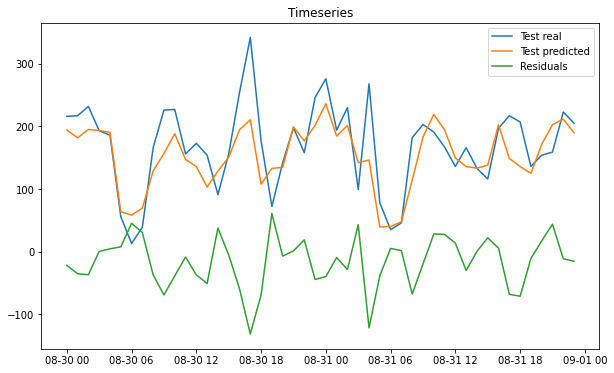

In [34]:
plt.figure(figsize=(10,6))
plt.title('Timeseries')
#plt.plot(train_target[-72:])
plt.plot(test_target[-48:])
plt.plot(pd.Series(data=test_prediction,index=test_target.index)[-48:])
plt.plot((pd.Series(data=test_prediction,index=test_target.index)-test_target)[-48:])
plt.legend(['Test real', 'Test predicted', 'Residuals'])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         1.,  1.,  0.,  0.,  6.,  1.,  1.,  2.,  1.,  7.,  5.,  7.,  8.,
        11., 17., 22., 15., 22., 41., 31., 32., 26., 35., 27., 28., 18.,
        18., 19., 11.,  9.,  4.,  7.,  1.,  1.,  3.,  0.,  1.]),
 array([-200.76042757, -194.92429448, -189.08816139, -183.25202829,
        -177.4158952 , -171.57976211, -165.74362902, -159.90749593,
        -154.07136283, -148.23522974, -142.39909665, -136.56296356,
        -130.72683047, -124.89069738, -119.05456428, -113.21843119,
        -107.3822981 , -101.54616501,  -95.71003192,  -89.87389882,
         -84.03776573,  -78.20163264,  -72.36549955,  -66.52936646,
         -60.69323336,  -54.85710027,  -49.02096718,  -43.18483409,
         -37.348701  ,  -31.51256791,  -25.67643481,  -19.84030172,
         -14.00416863,   -8.16803554,   -2.33190245,    3.50423065,
           9.34036374,   15.17649683,   21.01262992,   26.84876301,
          32.68489611,   38.5210292 

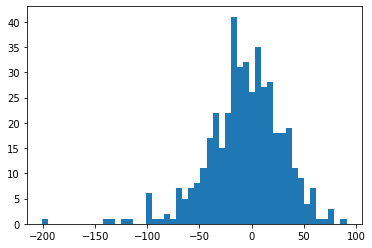

In [35]:
plt.hist((pd.Series(data=test_prediction,index=test_target.index)-test_target),bins=50)

У модели есть склонность к недооценке/занижению пиковых значений.

## Conclusion

The data has a pronounced seasonality pattern. Linear regression gives a reliable result. If we consider lags for 1 month and rolling mean for 1 month, we include many info about previous data and get good score, but the residuals have non symmetric distribution. Possibly this is due to the fact that the series is non stationary and its distributions changes in the end. That is if on wants to catch the latest changes, he must take less info. The model score becomes better, and the residuals are more symmetric. 
(1 week lags and 1 week moving average gives us RMSE about 35 at the test sample, since 1 month lags and MA gives RMSE=37).
